In [2]:
import numpy as np
import pandas as pd
import glob
import pytz
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar

# parsing xml data from iPhone Health app

In [2]:
# %run -i 'apple-health-data-parser' 'export.xml' 
%run -i 'apple-health-data-parser' 'data/export.xml' 

# the parser creates multiple separate csv files that are stored in data/ see original qs_ledger GitHub repo for more info

Reading data from data/export.xml . . . done
Unexpected node of type ExportDate.
Unexpected node of type Correlation.

Tags:
Correlation: 1
ExportDate: 1
Me: 1
Record: 259543
Workout: 195

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
creationDate: 259739
device: 203734
duration: 195
durationUnit: 195
endDate: 259739
sourceName: 259739
sourceVersion: 259027
startDate: 259739
type: 259544
unit: 248971
value: 259544
workoutActivityType: 195

Record types:
ActiveEnergyBurned: 30634
AppleWalkingSteadiness: 65
BasalEnergyBurned: 12781
BloodPressureDiastolic: 1
BloodPressureSystolic: 1
BodyFatPercentage: 1096
BodyMass: 1097
BodyMassIndex: 1095
DietaryEnergyConsumed: 1
DietaryWater: 2
DistanceWalkingRunning: 51365
FlightsClimbed: 13712
ForcedExpiratoryVolume1: 11
HKDataTypeSleepDuratio

In [3]:
# open step dataset after parsing
steps = pd.read_csv("data/StepCount.csv")


In [4]:
# what does it look like?
steps.tail(5)

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
51379,IsaPhone,16.0.3,"<<HKDevice: 0x282ceb7f0>, name:iPhone, manufac...",StepCount,count,2023-02-21 09:23:09 -0600,2023-02-21 09:12:19 -0600,2023-02-21 09:22:17 -0600,158
51380,IsaPhone,16.0.3,"<<HKDevice: 0x282ceb7f0>, name:iPhone, manufac...",StepCount,count,2023-02-21 09:33:20 -0600,2023-02-21 09:22:17 -0600,2023-02-21 09:31:57 -0600,362
51381,IsaPhone,16.0.3,"<<HKDevice: 0x282ceb7f0>, name:iPhone, manufac...",StepCount,count,2023-02-21 12:44:07 -0600,2023-02-21 12:34:01 -0600,2023-02-21 12:34:03 -0600,16
51382,IsaPhone,16.0.3,"<<HKDevice: 0x282ceb7f0>, name:iPhone, manufac...",StepCount,count,2023-02-21 13:19:48 -0600,2023-02-21 13:19:08 -0600,2023-02-21 13:19:36 -0600,22
51383,IsaPhone,16.3.1,"<<HKDevice: 0x282c81270>, name:iPhone, manufac...",StepCount,count,2023-02-21 15:38:55 -0600,2023-02-21 15:13:43 -0600,2023-02-21 15:13:59 -0600,13


In [5]:
steps.describe()

,value
count,51384.000000
mean,419.148276
std,1501.408168
min,1.000000
25%,29.000000
50%,143.000000
75%,486.000000
max,67680.000000


I need to prepare the data to make my graphs. First, let's check where the step data come from

In [6]:
#Get the unique instances of the column
steps['sourceName'].unique()

array(['IsaPhone', 'Power Sync for Fitbit'], dtype=object)

I want to only use my iphone data since it has data from the longest period and it also covers the period of my foot injury

## Timezones?

Check my data during October 2023, since we were in Croatia.


In [7]:
steps['date_pretimezonechange'] = pd.to_datetime(steps['startDate'], format="%Y-%m-%d %H:%M:%S %z")
steps['date_pretimezonechange'] = steps['date_pretimezonechange'].dt.date
steps.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,date_pretimezonechange
0,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 12:44:01 -0600,2021-09-29 12:32:58 -0600,2021-09-29 12:42:19 -0600,711,2021-09-29
1,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 12:55:15 -0600,2021-09-29 12:44:13 -0600,2021-09-29 12:47:26 -0600,58,2021-09-29
2,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 13:09:51 -0600,2021-09-29 12:58:48 -0600,2021-09-29 13:08:05 -0600,977,2021-09-29
3,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 13:22:02 -0600,2021-09-29 13:09:02 -0600,2021-09-29 13:14:03 -0600,178,2021-09-29
4,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 14:10:48 -0600,2021-09-29 13:59:46 -0600,2021-09-29 14:01:42 -0600,111,2021-09-29


In [8]:
#looking for dates where we were in Croatia
steps[(steps['date_pretimezonechange']>datetime.date(2022,10,20)) & (steps['date_pretimezonechange']<datetime.date(2022,10,25))]  



,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,date_pretimezonechange
48496,IsaPhone,15.6.1,"<<HKDevice: 0x282cc2850>, name:iPhone, manufac...",StepCount,count,2022-10-21 02:06:48 -0600,2022-10-21 01:54:48 -0600,2022-10-21 01:55:03 -0600,25,2022-10-21
48497,IsaPhone,15.6.1,"<<HKDevice: 0x282cc2850>, name:iPhone, manufac...",StepCount,count,2022-10-21 02:16:57 -0600,2022-10-21 02:05:28 -0600,2022-10-21 02:15:27 -0600,120,2022-10-21
48498,IsaPhone,15.6.1,"<<HKDevice: 0x282cc2850>, name:iPhone, manufac...",StepCount,count,2022-10-21 02:27:12 -0600,2022-10-21 02:15:27 -0600,2022-10-21 02:25:26 -0600,568,2022-10-21
48499,IsaPhone,15.6.1,"<<HKDevice: 0x282cc2850>, name:iPhone, manufac...",StepCount,count,2022-10-21 02:39:28 -0600,2022-10-21 02:25:26 -0600,2022-10-21 02:29:23 -0600,374,2022-10-21
48500,IsaPhone,15.6.1,"<<HKDevice: 0x282cc2850>, name:iPhone, manufac...",StepCount,count,2022-10-21 03:16:42 -0600,2022-10-21 03:04:19 -0600,2022-10-21 03:11:04 -0600,334,2022-10-21
...,...,...,...,...,...,...,...,...,...,...
48584,IsaPhone,16.0.3,"<<HKDevice: 0x282cea9e0>, name:iPhone, manufac...",StepCount,count,2022-10-24 12:42:41 -0600,2022-10-24 12:31:39 -0600,2022-10-24 12:31:44 -0600,2,2022-10-24
48585,IsaPhone,16.0.3,"<<HKDevice: 0x282cea9e0>, name:iPhone, manufac...",StepCount,count,2022-10-24 13:35:10 -0600,2022-10-24 13:25:02 -0600,2022-10-24 13:25:22 -0600,21,2022-10-24
48586,IsaPhone,16.0.3,"<<HKDevice: 0x282cea9e0>, name:iPhone, manufac...",StepCount,count,2022-10-24 14:15:36 -0600,2022-10-24 14:05:21 -0600,2022-10-24 14:11:33 -0600,44,2022-10-24
48587,IsaPhone,16.0.3,"<<HKDevice: 0x282cea9e0>, name:iPhone, manufac...",StepCount,count,2022-10-24 14:35:10 -0600,2022-10-24 14:22:08 -0600,2022-10-24 14:22:41 -0600,33,2022-10-24


In [9]:
# Extract date, year, month, day, day of the week, and hour components into separate columns

#making a copy of startDate column for later
steps['startDate_original']=steps['startDate']


steps['startDate']=pd.to_datetime(steps['startDate'], format="%Y-%m-%d %H:%M:%S %z")
steps['date'] = steps['startDate'].apply(lambda x: x.date().isoformat())
steps['year'] = steps['startDate'].apply(lambda x: x.year)
steps['month'] = steps['startDate'].apply(lambda x: x.month)
steps['day'] = steps['startDate'].apply(lambda x: x.day)
steps['day_of_week'] = steps['startDate'].apply(lambda x: x.weekday())
steps['hour'] = steps['startDate'].apply(lambda x: x.hour)

In [10]:
steps.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,date_pretimezonechange,startDate_original,date,year,month,day,day_of_week,hour
0,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 12:44:01 -0600,2021-09-29 12:32:58-06:00,2021-09-29 12:42:19 -0600,711,2021-09-29,2021-09-29 12:32:58 -0600,2021-09-29,2021,9,29,2,12
1,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 12:55:15 -0600,2021-09-29 12:44:13-06:00,2021-09-29 12:47:26 -0600,58,2021-09-29,2021-09-29 12:44:13 -0600,2021-09-29,2021,9,29,2,12
2,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 13:09:51 -0600,2021-09-29 12:58:48-06:00,2021-09-29 13:08:05 -0600,977,2021-09-29,2021-09-29 12:58:48 -0600,2021-09-29,2021,9,29,2,12
3,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 13:22:02 -0600,2021-09-29 13:09:02-06:00,2021-09-29 13:14:03 -0600,178,2021-09-29,2021-09-29 13:09:02 -0600,2021-09-29,2021,9,29,2,13
4,IsaPhone,15.0,"<<HKDevice: 0x282ca0f50>, name:iPhone, manufac...",StepCount,count,2021-09-29 14:10:48 -0600,2021-09-29 13:59:46-06:00,2021-09-29 14:01:42 -0600,111,2021-09-29,2021-09-29 13:59:46 -0600,2021-09-29,2021,9,29,2,13


In [11]:
steps['year'].unique()

array([2021, 2016, 2017, 2018, 2019, 2020, 2022, 2023])

In [12]:
#I will remove all data from before arriving in Chicago, so from 2016 to 2018
steps = steps.loc[(steps['year'] >= 2019) & (steps['year'] <= 2023)]

In [13]:
# getting a dataframe that sums steps by the hour increment for each date and keeping all other time info
#steps_by_date_hour = steps.groupby(['date','year', 'month', 'day',
   #    'day_of_week','hour'])['value'].sum().reset_index(name='Steps')

In [14]:
#steps_by_date_hour.head()

In [15]:
# getting a dataframe that sums steps by date increment and keeping all other time columns
steps_by_date=steps.groupby(['date','year', 'month', 'day',
       'day_of_week'])['value'].sum().reset_index(name='Steps')

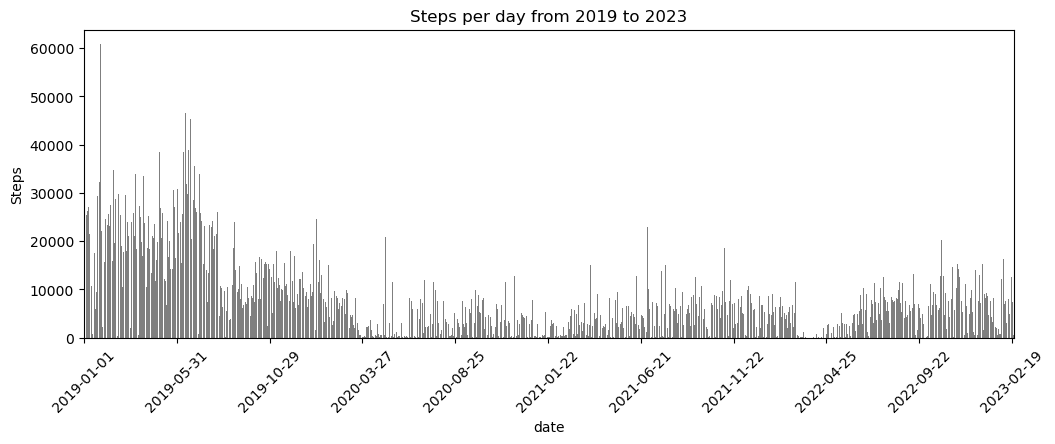

In [16]:
# making a bar plot of all my steps per day since 2019
plt.figure(figsize=(12,4))

sns.barplot(x="date", y="Steps", data=steps_by_date, alpha=0.5, color='black')
plt.xticks(range(len(steps_by_date)), steps_by_date['date'], rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.title('Steps per day from 2019 to 2023')
plt.savefig('stepcount2019-2023.svg',bbox_inches = 'tight')
plt.savefig('stepcount2019-2023.png',bbox_inches = 'tight',dpi=1200)
plt.show()


## Moving average

In [17]:
steps_by_date['MovingAverageSteps180'] = steps_by_date.Steps.rolling(window=180, center=True).mean()
steps_by_date['MovingAverageSteps120'] = steps_by_date.Steps.rolling(window=120, center=True).mean()
steps_by_date['MovingAverageSteps90'] = steps_by_date.Steps.rolling(window=90, center=True).mean()
steps_by_date['MovingAverageSteps60'] = steps_by_date.Steps.rolling(window=60, center=True).mean()
steps_by_date['MovingAverageSteps30'] = steps_by_date.Steps.rolling(window=30, center=True).mean()
steps_by_date['MovingAverageSteps14'] = steps_by_date.Steps.rolling(window=14, center=True).mean()
steps_by_date['MovingAverageSteps7'] = steps_by_date.Steps.rolling(window=7, center=True).mean()


<AxesSubplot:title={'center':'Daily step counts moving average over 30 days'}, xlabel='date'>

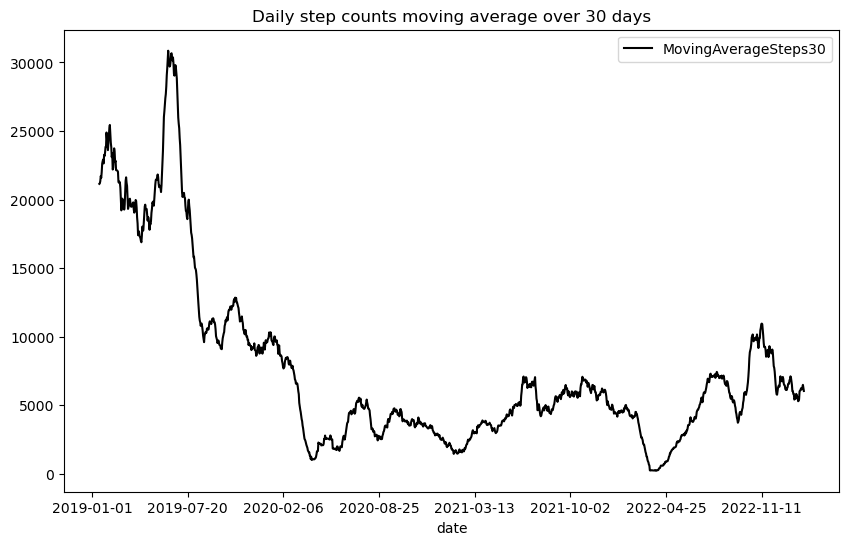

In [18]:
steps_by_date.plot(x='date', y='MovingAverageSteps30', title= 'Daily step counts moving average over 30 days', figsize=[10, 6]
, color='black')


In [19]:
steps_roll=steps_by_date[['date','MovingAverageSteps180','MovingAverageSteps120','MovingAverageSteps90','MovingAverageSteps60','MovingAverageSteps30','MovingAverageSteps14','MovingAverageSteps7']]
steps_roll_m=steps_roll.melt('date',var_name='MovingAverageSteps_Days',value_name='vals')


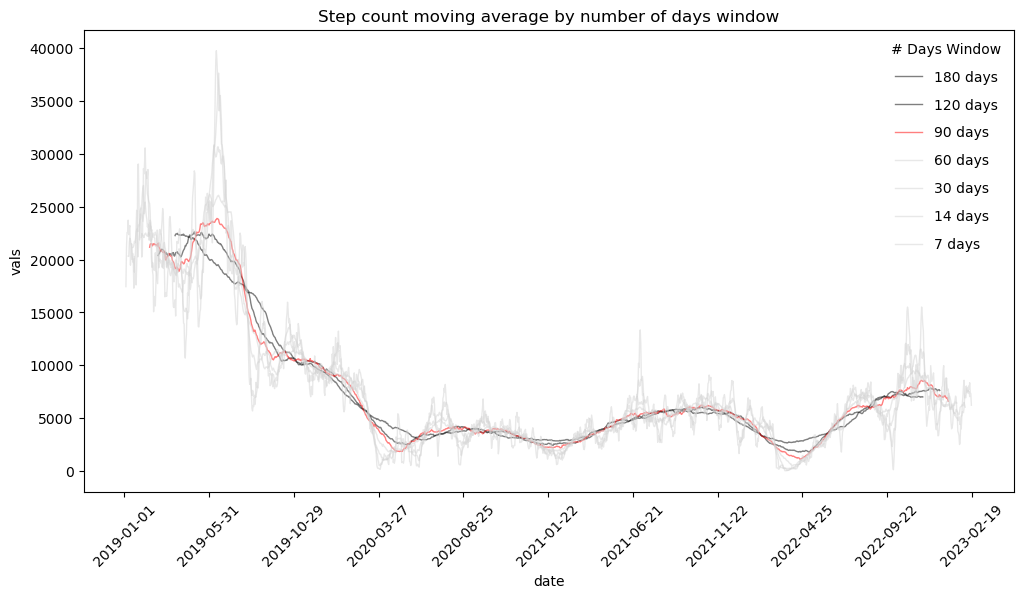

In [20]:
plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="vals", hue='MovingAverageSteps_Days', data=steps_roll_m, alpha=0.5, linewidth=1,palette=['black','black','red','lightgrey','lightgrey','lightgrey','lightgrey'])
plt.xticks(range(len(steps_by_date)), steps_by_date['date'], rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.title('Step count moving average by number of days window')

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='# Days Window',labels=['180 days', '120 days','90 days','60 days','30 days','14 days','7 days'])
plt.savefig('comparison_moving_average.svg', bbox_inches = 'tight')
plt.savefig('comparison_moving_average.png',bbox_inches = 'tight',dpi=1200)



<AxesSubplot:title={'center':'Daily step counts 3 montth moving average'}, xlabel='date'>

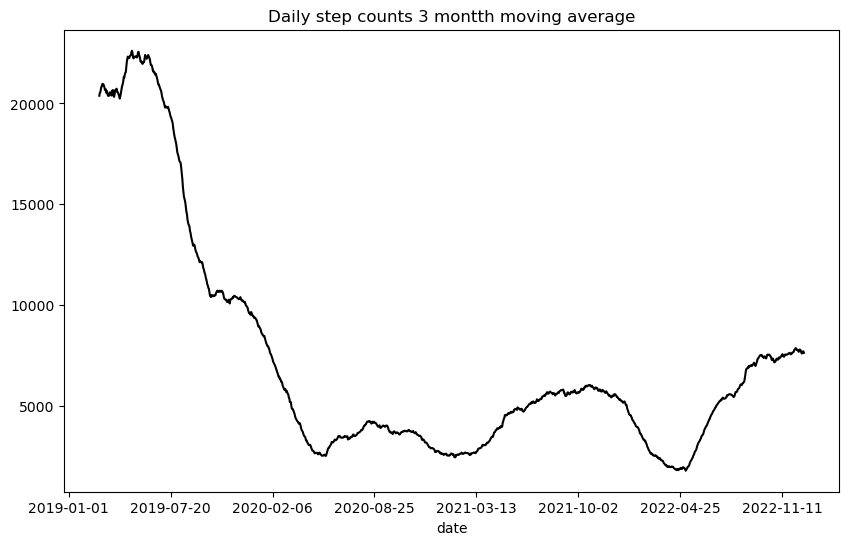

In [21]:
steps_by_date.plot(x='date', y='MovingAverageSteps120', title= 'Daily step counts 3 montth moving average',legend=None, figsize=[10, 6],color='black')




<Figure size 1200x600 with 0 Axes>

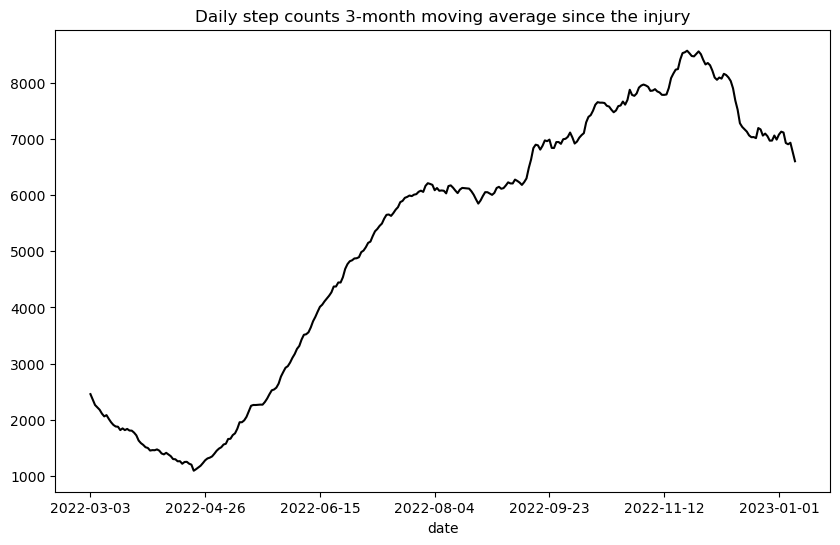

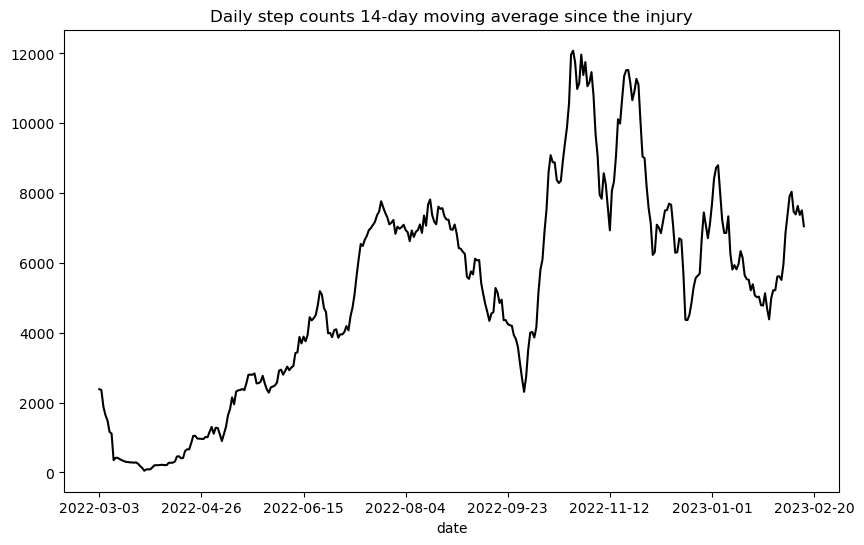

In [22]:
#let's look at the progress from my injury day March 3 2022 to today
start_date = '2022-03-03'
end_date = '2023-02-21'
plt.figure(figsize=(12,6))
mask = (steps_by_date['date'] >= start_date) & (steps_by_date['date'] <= end_date)
steps_by_date_filtered = steps_by_date.loc[mask]
steps_by_date_filtered.plot(x='date', y='MovingAverageSteps90', title='Daily step counts 3-month moving average since the injury', figsize=[10, 6],color='black',legend=None)
plt.savefig('sinceinjuryMA90.svg', bbox_inches = 'tight',dpi=1200)
plt.savefig('sinceinjuryMA90',bbox_inches = 'tight')

steps_by_date_filtered.plot(x='date', y='MovingAverageSteps14', title='Daily step counts 14-day moving average since the injury', figsize=[10, 6],color='black', legend=None)
plt.savefig('sinceinjuryMA14.svg', bbox_inches = 'tight')
plt.savefig('sinceinjuryMA14.png',bbox_inches = 'tight',dpi=1200)



In [23]:
steps_by_date.head()

,date,year,month,day,day_of_week,Steps,MovingAverageSteps180,MovingAverageSteps120,MovingAverageSteps90,MovingAverageSteps60,MovingAverageSteps30,MovingAverageSteps14,MovingAverageSteps7
0,2019-01-01,2019,1,1,1,1178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,2019,1,2,2,21944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,2019,1,3,3,21586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,2019,1,4,4,19621,NaN,NaN,NaN,NaN,NaN,NaN,17439.285714
4,2019-01-05,2019,1,5,5,25391,NaN,NaN,NaN,NaN,NaN,NaN,21132.285714


In [24]:
steps_by_date_by_dow=steps_by_date.groupby(['year','month',
       'day_of_week'])['Steps'].mean().reset_index(name='Steps')

In [25]:
steps_by_date_by_dow.head(20)

,year,month,day_of_week,Steps
0,2019,1,0,31014.75
1,2019,1,1,14617.80
2,2019,1,2,25577.00
3,2019,1,3,19725.80
4,2019,1,4,18771.75
5,2019,1,5,23304.50
6,2019,1,6,11135.75
7,2019,2,0,26749.75
8,2019,2,1,24268.25
9,2019,2,2,28392.50


In [26]:
steps_by_date_by_dow2022=steps_by_date_by_dow.loc[steps_by_date_by_dow['year'] ==2022]

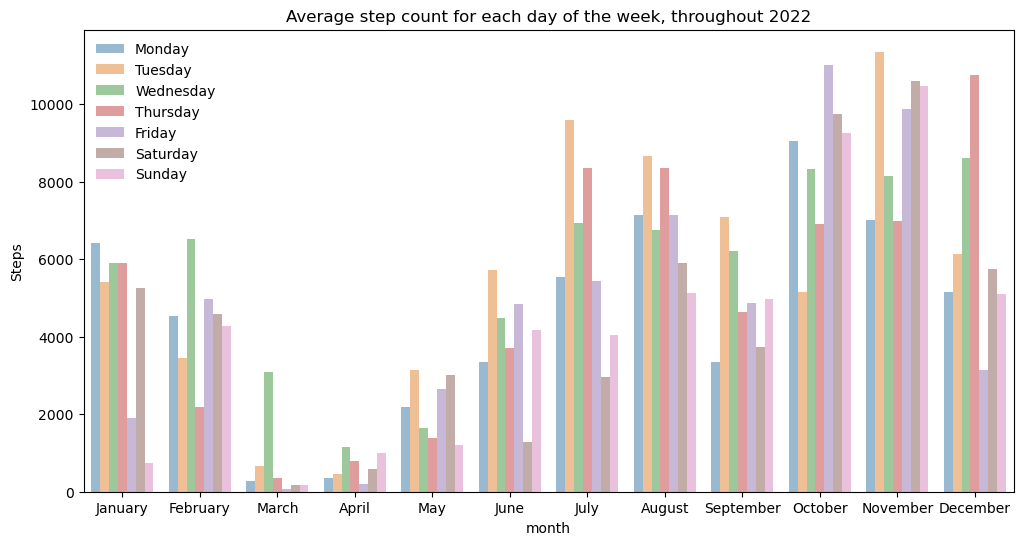

In [27]:
plt.figure(figsize=(12,6))

ax=sns.barplot(x="month", y="Steps", hue='day_of_week', data=steps_by_date_by_dow2022, alpha=0.5)

#x-axis month name
month_names = [calendar.month_name[i] for i in range(1, 13)]
ax.set_xticklabels(month_names)

#legend day of the week names
new_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, new_labels, title="", title_fontsize="large",frameon=False)
plt.title('Average step count for each day of the week, throughout 2022')
plt.savefig('stepdayofweek2022.svg', bbox_inches = 'tight')
plt.savefig('stepdayofweek2022.png',bbox_inches = 'tight',dpi=1200)



Compare average steps per hour for March and April, July and August, and December January

In [28]:
steps_OctNov2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,10,1)) & (steps['date_pretimezonechange']<datetime.date(2022,11,30))]  


In [29]:
steps_March2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,3,3)) & (steps['date_pretimezonechange']<datetime.date(2022,3,31))]  
steps_April2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,4,1)) & (steps['date_pretimezonechange']<datetime.date(2022,4,30))]  


steps_July2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,7,1)) & (steps['date_pretimezonechange']<datetime.date(2022,7,30))]  
steps_August2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,8,1)) & (steps['date_pretimezonechange']<datetime.date(2022,8,31))]  


steps_December2022=steps[(steps['date_pretimezonechange']>datetime.date(2022,12,3)) & (steps['date_pretimezonechange']<datetime.date(2022,12,31))]  
steps_January2023=steps[(steps['date_pretimezonechange']>datetime.date(2023,1,1)) & (steps['date_pretimezonechange']<datetime.date(2023,1,31))]  


In [30]:
#for each subset, calculate the average step count per hour
steps_March2022.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,date_pretimezonechange,startDate_original,date,year,month,day,day_of_week,hour
44898,IsaPhone,15.3.1,"<<HKDevice: 0x282c780a0>, name:iPhone, manufac...",StepCount,count,2022-03-04 08:20:48 -0600,2022-03-04 08:01:56-06:00,2022-03-04 08:01:59 -0600,16,2022-03-04,2022-03-04 08:01:56 -0600,2022-03-04,2022,3,4,4,8
44899,IsaPhone,15.3.1,"<<HKDevice: 0x282c780a0>, name:iPhone, manufac...",StepCount,count,2022-03-04 19:13:40 -0600,2022-03-04 18:55:42-06:00,2022-03-04 18:55:50 -0600,16,2022-03-04,2022-03-04 18:55:42 -0600,2022-03-04,2022,3,4,4,18
44900,IsaPhone,15.3.1,"<<HKDevice: 0x282c780a0>, name:iPhone, manufac...",StepCount,count,2022-03-04 19:39:03 -0600,2022-03-04 19:27:22-06:00,2022-03-04 19:27:24 -0600,9,2022-03-04,2022-03-04 19:27:22 -0600,2022-03-04,2022,3,4,4,19
44901,IsaPhone,15.3.1,"<<HKDevice: 0x282c780a0>, name:iPhone, manufac...",StepCount,count,2022-03-04 20:22:33 -0600,2022-03-04 20:11:30-06:00,2022-03-04 20:12:11 -0600,62,2022-03-04,2022-03-04 20:11:30 -0600,2022-03-04,2022,3,4,4,20
44902,IsaPhone,15.3.1,"<<HKDevice: 0x282c780a0>, name:iPhone, manufac...",StepCount,count,2022-03-05 12:19:47 -0600,2022-03-05 12:08:00-06:00,2022-03-05 12:08:02 -0600,13,2022-03-05,2022-03-05 12:08:00 -0600,2022-03-05,2022,3,5,5,12


In [31]:
steps_March2022_byhour=steps_March2022.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')
steps_April2022_byhour=steps_April2022.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')

steps_July2022_byhour=steps_July2022.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')
steps_August2022_byhour=steps_August2022.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')

steps_December2022_byhour=steps_December2022.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')
steps_January2023_byhour=steps_January2023.groupby(['year','month','hour'])['value'].mean().reset_index(name='Steps')

In [32]:
#check if each dataframe has 24 values

In [33]:
steps_March2022_byhour['hour'].unique()

array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23])

In [34]:
dict = {'year':['2022', '2022'],
        'month':[3, 3],
        'hour':[2, 3],
        'Steps':[0,0]
       }
df = pd.DataFrame(dict)
steps_March2022_byhour = pd.concat([steps_March2022_byhour, df], ignore_index=True)

#addind a column with period letter for the facet grid
steps_March2022_byhour['order']='A'
print(steps_March2022_byhour)



    year  month  hour      Steps order
0   2022      3     0  83.000000     A
1   2022      3     1  21.000000     A
2   2022      3     4  33.333333     A
3   2022      3     5  22.000000     A
4   2022      3     6  62.200000     A
5   2022      3     7  74.090909     A
6   2022      3     8  61.187500     A
7   2022      3     9  35.250000     A
8   2022      3    10  65.285714     A
9   2022      3    11  52.800000     A
10  2022      3    12  97.583333     A
11  2022      3    13  16.250000     A
12  2022      3    14  27.888889     A
13  2022      3    15  17.333333     A
14  2022      3    16  49.600000     A
15  2022      3    17   7.750000     A
16  2022      3    18  18.250000     A
17  2022      3    19  49.833333     A
18  2022      3    20  59.750000     A
19  2022      3    21  28.333333     A
20  2022      3    22  13.500000     A
21  2022      3    23   7.000000     A
22  2022      3     2   0.000000     A
23  2022      3     3   0.000000     A


In [35]:
steps_April2022_byhour['hour'].unique()

array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 22])

In [36]:
dict = {'year':['2022', '2022','2022','2022'],
        'month':[4, 4,4,4],
        'hour':[3, 6,21,23],
        'Steps':[0,0,0,0]
       }
df = pd.DataFrame(dict)
steps_April2022_byhour = pd.concat([steps_April2022_byhour, df], ignore_index=True)
steps_April2022_byhour['order']='B'
print(steps_April2022_byhour)


    year  month  hour       Steps order
0   2022      4     0   20.000000     B
1   2022      4     1   35.000000     B
2   2022      4     2    8.000000     B
3   2022      4     4   20.000000     B
4   2022      4     5    8.000000     B
5   2022      4     7   64.166667     B
6   2022      4     8   94.500000     B
7   2022      4     9   53.800000     B
8   2022      4    10   78.142857     B
9   2022      4    11   12.166667     B
10  2022      4    12  107.777778     B
11  2022      4    13   24.444444     B
12  2022      4    14  203.875000     B
13  2022      4    15  112.900000     B
14  2022      4    16  182.090909     B
15  2022      4    17  162.944444     B
16  2022      4    18  154.769231     B
17  2022      4    19  157.400000     B
18  2022      4    20   16.800000     B
19  2022      4    22   16.000000     B
20  2022      4     3    0.000000     B
21  2022      4     6    0.000000     B
22  2022      4    21    0.000000     B
23  2022      4    23    0.000000     B


In [37]:
steps_July2022_byhour['hour'].unique()

array([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23])

In [38]:
dict = {'year':['2022', '2022','2022'],
        'month':[7,7,7],
        'hour':[0,1,3],
        'Steps':[0,0,0]
       }
df = pd.DataFrame(dict)
steps_July2022_byhour = pd.concat([steps_July2022_byhour, df], ignore_index=True)
steps_July2022_byhour['order']='C'
print(steps_July2022_byhour)


    year  month  hour       Steps order
0   2022      7     2   12.000000     C
1   2022      7     4   76.000000     C
2   2022      7     5   79.250000     C
3   2022      7     6  223.531250     C
4   2022      7     7  286.291667     C
5   2022      7     8  351.706897     C
6   2022      7     9  233.109091     C
7   2022      7    10  254.866667     C
8   2022      7    11  294.064516     C
9   2022      7    12  221.517241     C
10  2022      7    13  223.277778     C
11  2022      7    14  304.813953     C
12  2022      7    15  320.666667     C
13  2022      7    16  459.000000     C
14  2022      7    17  296.755102     C
15  2022      7    18  200.682927     C
16  2022      7    19  227.761905     C
17  2022      7    20  104.437500     C
18  2022      7    21   27.000000     C
19  2022      7    22  111.000000     C
20  2022      7    23   89.000000     C
21  2022      7     0    0.000000     C
22  2022      7     1    0.000000     C
23  2022      7     3    0.000000     C


In [39]:
steps_August2022_byhour['hour'].unique()

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21])

In [40]:
dict = {'year':['2022', '2022','2022','2022','2022'],
        'month':[8,8,8,8,8],
        'hour':[1,3,2,22,23],
        'Steps':[0,0,0,0,0]
       }
df = pd.DataFrame(dict)
steps_August2022_byhour = pd.concat([steps_August2022_byhour, df], ignore_index=True)
steps_August2022_byhour['order']='D'
print(steps_August2022_byhour)

    year  month  hour       Steps order
0   2022      8     0    9.000000     D
1   2022      8     4   36.000000     D
2   2022      8     5   84.600000     D
3   2022      8     6  250.450000     D
4   2022      8     7  308.596774     D
5   2022      8     8  437.782609     D
6   2022      8     9  304.200000     D
7   2022      8    10  297.311111     D
8   2022      8    11  305.682927     D
9   2022      8    12  292.285714     D
10  2022      8    13  291.361111     D
11  2022      8    14  340.380952     D
12  2022      8    15  405.921875     D
13  2022      8    16  387.596154     D
14  2022      8    17  277.150943     D
15  2022      8    18   85.705882     D
16  2022      8    19   43.833333     D
17  2022      8    20   14.125000     D
18  2022      8    21   45.500000     D
19  2022      8     1    0.000000     D
20  2022      8     3    0.000000     D
21  2022      8     2    0.000000     D
22  2022      8    22    0.000000     D
23  2022      8    23    0.000000     D


In [41]:
steps_December2022_byhour['hour'].unique()

array([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23])

In [42]:
dict = {'year':['2022', '2022'],
        'month':[12,12],
        'hour':[1,3],
        'Steps':[0,0]
       }
df = pd.DataFrame(dict)
steps_December2022_byhour = pd.concat([steps_December2022_byhour, df], ignore_index=True)
steps_December2022_byhour['order']='E'
print(steps_December2022_byhour)


    year  month  hour       Steps order
0   2022     12     0   43.000000     E
1   2022     12     2   21.000000     E
2   2022     12     4   15.000000     E
3   2022     12     5   43.750000     E
4   2022     12     6  121.416667     E
5   2022     12     7  173.888889     E
6   2022     12     8  292.135135     E
7   2022     12     9  301.074074     E
8   2022     12    10  366.311688     E
9   2022     12    11  313.704545     E
10  2022     12    12  286.277778     E
11  2022     12    13  269.781250     E
12  2022     12    14  253.560976     E
13  2022     12    15  319.869565     E
14  2022     12    16  426.540000     E
15  2022     12    17  322.511111     E
16  2022     12    18  389.933333     E
17  2022     12    19  202.928571     E
18  2022     12    20   41.384615     E
19  2022     12    21   29.642857     E
20  2022     12    22   30.000000     E
21  2022     12    23   28.000000     E
22  2022     12     1    0.000000     E
23  2022     12     3    0.000000     E


In [43]:
steps_January2023_byhour['hour'].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [44]:
dict = {'year':['2023','2023','2023','2023','2023','2023','2023'],
        'month':[1,1,1,1,1,1,1],
        'hour':[0,1,2,3,4,5,6],
        'Steps':[0,0,0,0,0,0,0]
       }
df = pd.DataFrame(dict)
steps_January2023_byhour = pd.concat([steps_January2023_byhour, df], ignore_index=True)
steps_January2023_byhour['order']='F'
print(steps_January2023_byhour)


    year  month  hour       Steps order
0   2023      1     7   57.769231     F
1   2023      1     8  223.424242     F
2   2023      1     9  359.583333     F
3   2023      1    10  428.561404     F
4   2023      1    11  427.438596     F
5   2023      1    12  231.921053     F
6   2023      1    13  241.653061     F
7   2023      1    14  409.177778     F
8   2023      1    15  411.297872     F
9   2023      1    16  351.756098     F
10  2023      1    17  220.645833     F
11  2023      1    18  216.178571     F
12  2023      1    19  122.000000     F
13  2023      1    20   65.521739     F
14  2023      1    21   23.500000     F
15  2023      1    22   18.000000     F
16  2023      1    23   13.000000     F
17  2023      1     0    0.000000     F
18  2023      1     1    0.000000     F
19  2023      1     2    0.000000     F
20  2023      1     3    0.000000     F
21  2023      1     4    0.000000     F
22  2023      1     5    0.000000     F
23  2023      1     6    0.000000     F


In [45]:
#concatenate all subsets back together
steps_comp_byhour=pd.concat([steps_March2022_byhour, steps_April2022_byhour, steps_July2022_byhour, steps_August2022_byhour,steps_December2022_byhour,steps_January2023_byhour], ignore_index=True)


/Users/isabellevea/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


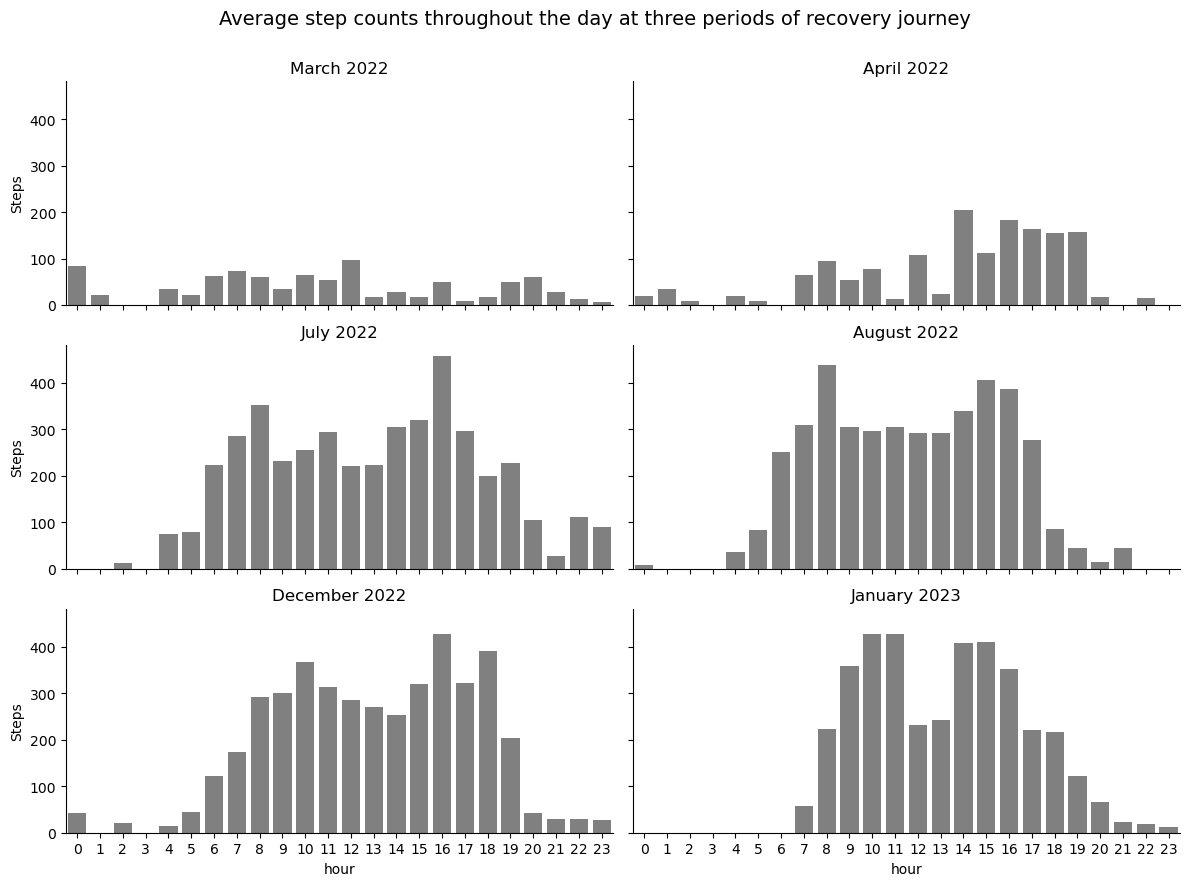

In [48]:
# create a FacetGrid with 2 columns
g = sns.FacetGrid(steps_comp_byhour, col='order',col_wrap=2, height=3, aspect=2)

# create a bar plot for each dataframe in the grid
g.map(sns.barplot, 'hour', 'Steps', color='grey')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average step counts throughout the day at three periods of recovery journey', size=14)

#change title for each fig
titles = ['March 2022','April 2022', 'July 2022', 'August 2022','December 2022','January 2023']
for g,title in zip(g.axes.flatten(),titles):
    g.set_title(title )

plt.savefig('houroftheday.svg', bbox_inches = 'tight')
plt.savefig('houroftheday.png',bbox_inches = 'tight',dpi=1200)

# show the plot
plt.show()

